# Vitrify for the MNIST Dataset

## Imports

In [1]:
import os
import sys

# Untie local dependency
cwd = os.getcwd().split("/")
local_repo_path = "/".join(cwd[:-1])
sys.path.insert(0, local_repo_path)

from src.models.multi_layer_perceptron import MultiLayerPerceptron
from src.models.soft_decision_tree import SoftBinaryDecisionTree
from src.models.variational_autoencoder import VariationalAutoEncoder
from src.models.convolutional_dnn import ConvDNN
from src.data.make_dataset import load_data, join_data
from src.visualization.visualize import draw_tree
from src.utils import balanced_sample_maker

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K

from sklearn.utils import shuffle

Using TensorFlow backend.


## Get the MNIST data

In [2]:
# Load the data (To download data from scratch, set already_downloaded=False)
data = load_data(dataset="MNIST", already_downloaded=True)

# Get the number of input features
n_rows, n_cols = np.shape(data["x_train"])[1:]
n_features = n_rows * n_cols
n_classes = np.unique(data["y_train"]).shape[0]

Let's look at the structure of the data:

In [3]:
for key, array in data.items():
    print(key, " ==>", np.shape(array))

y_train_one_hot  ==> (50000, 10)
x_test_flat  ==> (10000, 784)
x_train  ==> (50000, 28, 28)
x_test  ==> (10000, 28, 28)
y_train  ==> (50000,)
y_test_one_hot  ==> (10000, 10)
y_test  ==> (10000,)
x_valid  ==> (10000, 28, 28)
y_valid  ==> (10000,)
y_valid_one_hot  ==> (10000, 10)
x_valid_flat  ==> (10000, 784)
x_train_flat  ==> (50000, 784)


Here, the **data** variable is a dictionary, consisting of numpy arrays. Above we can see the shapes of the MNIST data in our dictionary. We can also inspect the other variables we created above:

In [4]:
print("n_rows: ", n_rows)
print("n_cols: ", n_cols)
print("n_features: ", n_features)
print("n_classes: ", n_classes)

n_rows:  28
n_cols:  28
n_features:  784
n_classes:  10


Let's visualise the training data with their labels:

<Figure size 432x288 with 0 Axes>

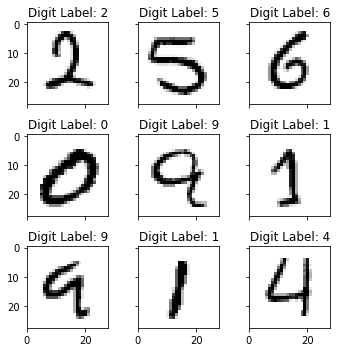

In [53]:
images_to_plot = 9
random_indices = np.random.choice(range(50000), images_to_plot)

sample_images = data["x_train_flat"][random_indices, :]
sample_labels = data["y_train"][random_indices]

plt.clf()
plt.style.use("seaborn-muted")

fig, axes = plt.subplots(3, 3, 
                         figsize=(5,5),
                         sharex=True, sharey=True,
                         subplot_kw=dict(aspect="equal"))

for i in range(images_to_plot):
    
    subplot_row = i // 3 
    subplot_col = i % 3  
    ax = axes[subplot_row, subplot_col]

    plottable_image = np.reshape(sample_images[i, :], (28, 28))
    ax.imshow(plottable_image, cmap="gray_r")
    
    ax.set_title("Digit Label: {}".format(sample_labels[i]))
    ax.set_xbound([0, 28])

plt.tight_layout()
plt.show()

Thus, in summary, our training data (**"x_train"**) consists of 50000 28x28 images of handwritten integers, with the labels saying what digit the image depicts (**"y_train"**). We also have a flattend version of the images (**"x_train_flat"**) and one-hot encoded labels (**"y_train_one_hot"**). This is the same for our validation and test data, both consisting of 10000 examples.

# Stage 1: Train the VAE

Start off by initialising the VAE model:

In [6]:
# Create VAE
vae = VariationalAutoEncoder(
    name = "vae_mnist",
    num_inputs = n_features,
    # If true, training info is outputted to stdout
    keras_verbose = False,
    # A summary of the NN is printed to stdout
    print_model_summary = False,
    # Size of latent dimension
    latent_dim = 20,
    # Specify the encoder layers [units, activation, dropout, l2, bias]
    encoder_layers = [
        [512, "relu", 0.0, 0.0, True, "gaussian"],
        [256, "relu", 0.0, 0.0, True, "gaussian"],
        [128, "relu", 0.0, 0.0, True, "gaussian"]
    ],
    # Specify the decoder layers [units, activation, dropout, l2, bias]
    decoder_layers = [
        [128, "relu", 0.0, 0.0, True, "gaussian"],
        [256, "relu", 0.0, 0.0, True, "gaussian"],
        [512, "relu", 0.0, 0.0, True, "gaussian"]
    ],
    # The final output layer's activation function
    final_activation = "sigmoid",
    # The maximum number of epochs to run
    epochs = 1000,
    # The batch size to use in the VAE
    batch_size = 250,
    # The learning rate used in optimisation
    learning_rate = 0.001,
    # If this many stagnant epochs are seen, stop training
    stopping_patience = 10
)

Next, we train our model. By setting `load_model=True`, we load a previously trained model. If you want to train the VAE model from scratch, set `load_model=False`. The VAE does not receive any target data, seeing as it is not trying to predict the labels, but rather trying to reconstruct its input. Thus, we only pass the flattened training and validation data to the model.

In [7]:
# Train VAE
vae.train(data["x_train_flat"], data["x_valid_flat"], load_model=True)

Loaded vae_mnist model from disk


In [8]:
# Evaluate VAE
vae_results = vae.evaluate(data["x_test_flat"])

accuracy: Nan | loss: 99.77282506103515


With our trained VAE model, we can generate new data. Here, we generate 20000 additional data points:

In [9]:
# Generate new data
x_gen_flat = vae.sample(20000)
print(np.shape(x_gen_flat))

(20000, 784)


Lets visualise some results from our VAE model and the generated data:

<Figure size 432x288 with 0 Axes>

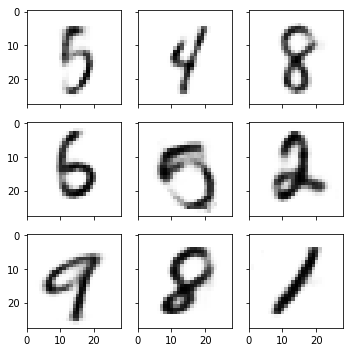

In [10]:
# Reshape to images
x_gen = np.array([np.reshape(x_gen_flat[i], [n_rows, n_cols]) for i in range(len(x_gen_flat))])

images_to_plot = 9
random_indices = np.random.choice(range(20000), images_to_plot)

sample_images = x_gen[random_indices, :]

plt.clf()
plt.style.use("seaborn-muted")

fig, axes = plt.subplots(3, 3, 
                         figsize=(5,5),
                         sharex=True, sharey=True,
                         subplot_kw=dict(aspect="equal"))

for i in range(images_to_plot):
    
    subplot_row = i // 3 
    subplot_col = i % 3  
    ax = axes[subplot_row, subplot_col]

    plottable_image = np.reshape(sample_images[i, :], (28, 28))
    ax.imshow(plottable_image, cmap="gray_r")
    
    ax.set_xbound([0, 28])

plt.tight_layout()
plt.show()

Here we can see some of the generated images from our VAE model. They are still unlabelled.

# Stage 2: Train the MLP and CNN

Start off by initialising the MLP model:

In [11]:
# Create MLP
mlp = MultiLayerPerceptron(
    name = "mlp_mnist",
    num_inputs = n_features,
    num_outputs = n_classes,
    # If true, training info is outputted to stdout
    keras_verbose = False,
    # A summary of the NN is printed to stdout
    print_model_summary = False,
    # ff_layers = [units, activation, regularization, dropout, use_bias]
    ff_layers = [
        [512, "relu", 0.0, 0.2, True, "gaussian"],
        [512, "relu", 0.0, 0.2, True, "gaussian"],
        [512, "relu", 0.0, 0.2, True, "gaussian"]
    ],
    # The final output layer's activation function
    final_activation = "softmax",
    # The objective function for the NN
    objective = "categorical_crossentropy",
    # The maximum number of epochs to run
    epochs = 20,
    # The batch size to use in the NN
    batch_size = 128,
    # The learning rate used in optimization
    learning_rate = 0.001,
    # If this many stagnant epochs are seen, stop training
    stopping_patience = 20
)

The same format as with the VAE applies, except here we provide the model with the necessary targets:

In [12]:
# Train MLP
mlp.train(
    data["x_train_flat"], data["y_train_one_hot"],
    data["x_valid_flat"], data["y_valid_one_hot"], load_model=True)

Loaded mlp_mnist model from disk


In [13]:
# Evaluate MLP
mlp_results = mlp.evaluate(data["x_test_flat"], data["y_test_one_hot"])

accuracy: 98.15% | loss: 0.08506726239238639


The MLP model achieved an accuracy of 98.15% on the test set. Next, we do the same for the CNN model:

In [14]:
# Create CNN
cnn = ConvDNN(
    name = "cnn_mnist",
    img_rows = n_rows,
    img_cols = n_cols,
    num_outputs = n_classes,
    # If true, training info is outputted to stdout
    keras_verbose = False,
    # A summary of the NN is printed to stdout
    print_model_summary = False,
    # Convolutional layers
    conv_layers = [
        # Layer, filters, kernel size, strides, padding, activation, use bias, kernel reg, bias reg, activity reg,
        # dropout (after layers)
        ["conv2d", 32, (3, 3), (1, 1), "valid", "relu", True, 0.0, 0.0, 0.0, 0.0],
        ["conv2d", 64, (3, 3), (1, 1), "valid", "relu", True, 0.0, 0.0, 0.0, 0.0],
        # Layer, pool size, stride, padding, dropout
        ["max_pool2d", (2, 2), None, "valid", 0.25],
    ],
    # ff_layers = [units, activation, regularization, dropout, use_bias]
    ff_layers = [
        [128, "relu", 0.0, 0.2, True, "normal"]
    ],
    # The final output layer's activation function
    final_activation = "softmax",
    # The objective function for the NN
    objective = "categorical_crossentropy",
    # The maximum number of epochs to run
    epochs = 20,
    # The batch size to use in the NN
    batch_size = 128,
    # The learning rate used in optimization
    learning_rate = 0.001,
    # If this many stagnant epochs are seen, stop training
    stopping_patience = 20
)

For the CNN model, we do not use the flattened training data:

In [15]:
# Train CNN
cnn.train(
    data["x_train"], data["y_train_one_hot"],
    data["x_valid"], data["y_valid_one_hot"], load_model=True)

Loaded cnn_mnist model from disk


In [16]:
# Evaluate CNN
cnn_results = cnn.evaluate(data["x_test"], data["y_test_one_hot"])

accuracy: 99.21% | loss: 0.034443770900733604


The CNN model slightly outperformed the standard MLP model, achieving an accuracy of 99.21% on the test set.

# Stage 3: Produce soft targets for our interpretable model

We will now use our trained CNN model to:
1. Relabel our original training data, **x_train**
2. Give labels to our unlabelled, generated data, **x_gen**

In [17]:
# Get CNN labels
y_cnn_train = cnn.predict(data["x_train"])
y_gen = cnn.predict(x_gen)

Now we combine both the original training data and the generated data, as well as their new soft target labels, and shuffle them:

In [18]:
# Combine x_train and x_gen
x_both = join_data([data["x_train"], x_gen])

# Flatten them to use it with our interpretable model
x_both = x_both.reshape((x_both.shape[0], -1))

# Combine y_cnn_train and y_gen
y_both = join_data([y_cnn_train, y_gen])

# Shuffle the data
x_both, y_both = shuffle(x_both, y_both)

print("x_both ==>", np.shape(x_both))
print("y_both ==>", np.shape(y_both))

x_both ==> (70000, 784)
y_both ==> (70000, 10)


Thus, we have increased our training data from 50000 samples to 70000, where each sample now has a soft target produced by the CNN model, which we are going to approximate.

# Stage 4: Train our interpretable model, the SDT

For the sake of comparison, we will train three separate models:
1. SDT using only the original data with original hard targets.
2. SDT using only the original data with new soft targets (provided by the CNN in the third stage).
3. SDT using the generated and the original data with soft targets.

## 1) SDT using only the original data with original hard targets

In [19]:
# Create SDT
sdt_raw = SoftBinaryDecisionTree(
    name = "sdt_raw_mnist",
    num_inputs = n_features,
    num_outputs = n_classes,
    # If true, training info is outputted to stdout
    keras_verbose = False,
    # A summary of the NN is printed to stdout
    print_model_summary = False,
    # Hyperparameters
    max_depth = 4,
    penalty_strength = 1e+1,
    penalty_decay = 0.25,
    inv_temp = 0.01,
    ema_win_size = 1000,
    # The learning rate used in optimization
    learning_rate = 5e-03,
    epochs = 40,
    batch_size = 4,
    # If this many stagnant epochs are seen, stop training
    stopping_patience = 20
)

Hyperparameters:
- `max_depth`: the maximum depth of the tree in terms of its inner nodes. This excludes leaves.
- `penalty_strength`: regularisation penalty strength.
- `penalty_decay`: regularisation penalty decay as a function of depth.
- `inv_temp`: scale the logits of the inner nodes to avoid very soft decisions.
- `ema_win_size`: scaling factor to the default size of the window used to calculate moving averages (growing exponentially with depth) of node and path probabilities.
- `batch_size`: we use a small one, because with increasing depth and thus a large amount of leaf bigots, larger batch sizes cause their loss terms to be scaled down too much by averaging, which results in poor optimisation properties. 

In [20]:
# Train SDT RAW
sdt_raw.train(
    data["x_train_flat"], data["y_train_one_hot"],
    data["x_valid_flat"], data["y_valid_one_hot"], load_model=True)

Built tree has 16 leaves out of 31 nodes
INFO:tensorflow:Restoring parameters from /home/zander/thesis/vitrify/models/sdt_raw_mnist/sdt_raw_mnist
Loaded sdt_raw_mnist model from disk


In [21]:
# Evaluate SDT RAW
sdt_raw_results = sdt_raw.evaluate(data["x_test_flat"], data["y_test_one_hot"])

accuracy: 78.88% | loss: 17.66645542907715


The test accuracy of our SDT model trained on the original data and labels is 78.88%.

## 2) SDT using only the original data with new soft targets (provided by the CNN in the third stage)

In [55]:
# Create SDT CNN
sdt_cnn = SoftBinaryDecisionTree(
    name = "sdt_cnn_mnist",
    num_inputs = n_features,
    num_outputs = n_classes
)

Note that although the model parameters are hidden in the implementation above, they are the same as the first SDT. We now train this model with the soft targets from the CNN, but still use the hard targets in validation and testing.

In [56]:
# Train SDT CNN
sdt_cnn.train(
    data["x_train_flat"], y_cnn_train,
    data["x_valid_flat"], data["y_valid_one_hot"], load_model=True)

Built tree has 16 leaves out of 31 nodes
INFO:tensorflow:Restoring parameters from /home/zander/thesis/vitrify/models/sdt_cnn_mnist/sdt_cnn_mnist
Loaded sdt_cnn_mnist model from disk


In [57]:
# Evaluate SDT CNN
sdt_cnn_results = sdt_cnn.evaluate(data["x_test_flat"], data["y_test_one_hot"])

accuracy: 90.94% | loss: 8.524216766357421


By using the soft targets, we increased the accuracy of our interpretable SDT from 78.88% to 90.94%. We can now also visualise our models and gain some insights into their decision making:

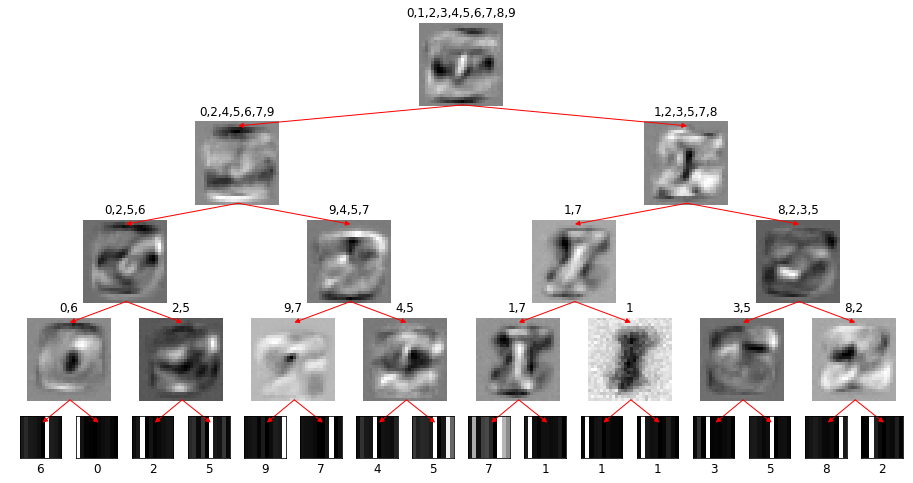

In [58]:
draw_tree(sdt_cnn, n_rows, n_cols)

The image above portrays our model with its various filters. Now lets see how this model tries to classify a "9":

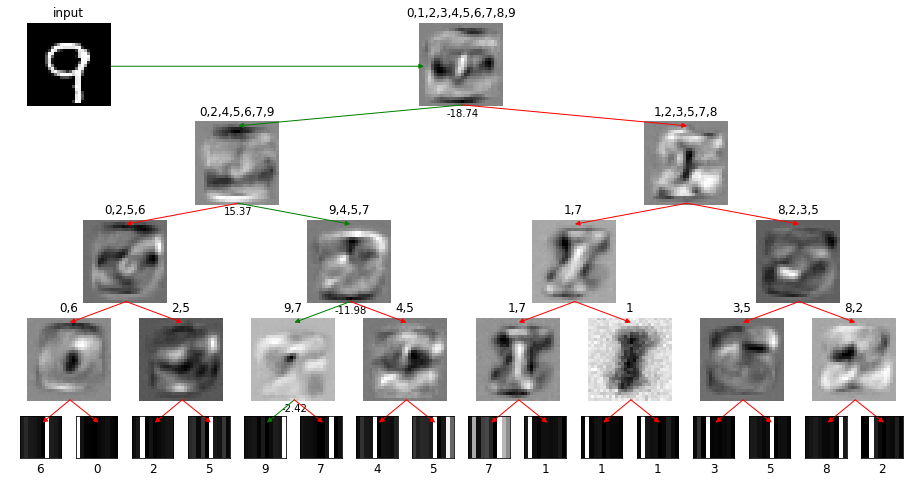

In [84]:
# This is the digit we wish to see for our model
digit = 9

sample_index = np.random.choice(np.where(np.argmax(data["y_test_one_hot"], axis=1) == digit)[0])
input_img = data["x_test"][sample_index]

draw_tree(sdt_cnn, n_rows, n_cols, input_img=input_img)

This now shows the decision path for our SDT model in trying to classify the input image. To further highlight how this decision is made, we can set `show_correlation=True`: 

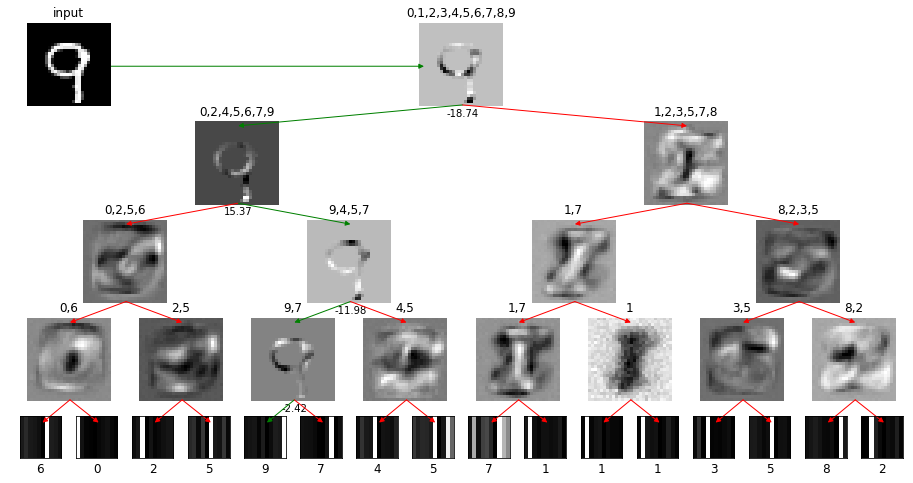

In [85]:
draw_tree(sdt_cnn, n_rows, n_cols, input_img=input_img, show_correlation=True)

On the maximum probability path, there are now correlations of the input image with the node filters. The homogeneous areas give a frame of reference for the colour where the filter pixels are zero. This is set up to correspond to the black areas in the input image. All the lighter pixels from this correspond to positive correlation coefficients. All the darker pixels correspond to negative correlation coefficients. In the last input-masked filter on the path to prediction, one can draw insight from how this model recognises "9" from "7". The lighter correlations (positive correlations) in the bottom loop of the filter, differentiates the "9" from the "7", which makes sense.

## 3) SDT using the generated and the original data with soft targets

In [28]:
# Create SDT VAE
sdt_vae = SoftBinaryDecisionTree(
    name = "sdt_cnn_vae_mnist",
    num_inputs = n_features,
    num_outputs = n_classes
)

In [29]:
# Train SDT VAE
sdt_vae.train(
    x_both, y_both,
    data["x_valid_flat"], data["y_valid_one_hot"], load_model=True)

Built tree has 16 leaves out of 31 nodes
INFO:tensorflow:Restoring parameters from /home/zander/thesis/vitrify/models/sdt_cnn_vae_mnist/sdt_cnn_vae_mnist
Loaded sdt_cnn_vae_mnist model from disk


In [30]:
# Evaluate SDT VAE
sdt_vae_results = sdt_vae.evaluate(data["x_test_flat"], data["y_test_one_hot"])

accuracy: 87.17% | loss: 9.309568546295166


The addition of the generated data to our SDT did not perform better than the SDT without the generated data, achieving an accuracy of 87.17% on the test data. We suspect the following reasons for this:

1. The MNIST dataset is already a large dataset, consisting of 50000 images without the validation and test data. The addition of generated data did not aid in achieving better generalisability, and instead added more noise to the model. The noise is introduced from the fact that although the generated images are good, they are not perfect, with some being blurry.
2. The slight class imbalance in the generated data could also potentially skew the model, giving more certainty to oversampled classes.
3. The accuracy achieved by the SDT without generated data might be the upper limit of what this model is able to achieve. Although this model is a good function approximator, it would be unreasonable to expect from it to outperform the DNN or CNN, even with additional data. This again showcases the trade-off between predictability and interpretability.

From point 1 above, we decided to conduct another experiment, where we significantly downsampled the original data to mimic a scenario where one does not have enough data at one's disposal.

# Downsampling of the data

In [31]:
# Downsample the data
x_train_flat_ds, y_train_ds, indices = balanced_sample_maker(data["x_train_flat"], data["y_train"], 10000,
                                                             random_seed=1234)

x_valid_flat_ds, y_valid_ds, indices = balanced_sample_maker(data["x_valid_flat"], data["y_valid"], 5000,
                                                             random_seed=1234)

x_test_flat_ds, y_test_ds, indices = balanced_sample_maker(data["x_test_flat"], data["y_test"], 5000,
                                                           random_seed=1234)

# Create other data
x_train_ds = x_train_flat_ds.reshape((x_train_flat_ds.shape[0], n_rows, n_cols))
y_train_one_hot_ds = tf.keras.utils.to_categorical(y_train_ds, n_classes)

x_valid_ds = x_valid_flat_ds.reshape((x_valid_flat_ds.shape[0], n_rows, n_cols))
y_valid_one_hot_ds = tf.keras.utils.to_categorical(y_valid_ds, n_classes)

x_test_ds = x_test_flat_ds.reshape((x_test_flat_ds.shape[0], n_rows, n_cols))
y_test_one_hot_ds = tf.keras.utils.to_categorical(y_test_ds, n_classes)

# Print shapes
print("y_train_one_hot_ds", " ==>", np.shape(y_train_one_hot_ds))
print("x_test_flat_ds", " ==>", np.shape(x_test_flat_ds))
print("x_train_ds", " ==>", np.shape(x_train_ds))
print("x_test_ds", " ==>", np.shape(x_test_ds))
print("y_train_ds", " ==>", np.shape(y_train_ds))
print("y_test_one_hot_ds", " ==>", np.shape(y_test_one_hot_ds))
print("y_test_ds", " ==>", np.shape(y_test_ds))
print("x_valid_ds", " ==>", np.shape(x_valid_ds))
print("y_valid_ds", " ==>", np.shape(y_valid_ds))
print("y_valid_one_hot_ds", " ==>", np.shape(y_valid_one_hot_ds))
print("x_valid_flat_ds", " ==>", np.shape(x_valid_flat_ds))
print("x_train_flat_ds", " ==>", np.shape(x_train_flat_ds))

y_train_one_hot_ds  ==> (10000, 10)
x_test_flat_ds  ==> (5000, 784)
x_train_ds  ==> (10000, 28, 28)
x_test_ds  ==> (5000, 28, 28)
y_train_ds  ==> (10000,)
y_test_one_hot_ds  ==> (5000, 10)
y_test_ds  ==> (5000,)
x_valid_ds  ==> (5000, 28, 28)
y_valid_ds  ==> (5000,)
y_valid_one_hot_ds  ==> (5000, 10)
x_valid_flat_ds  ==> (5000, 784)
x_train_flat_ds  ==> (10000, 784)


Thus, we have created new data variables, each appended with "ds". We will now use these variables and repeat the _vitrify_ process.

# Stage 1: Train the VAE

Again we start off by initialising the VAE model. Note the name change.

In [32]:
# Clear our current Keras session
K.clear_session()

# Create VAE
vae = VariationalAutoEncoder(
    name = "vae_mnist_ds",
    num_inputs = n_features,
    # If true, training info is outputted to stdout
    keras_verbose = False,
    # A summary of the NN is printed to stdout
    print_model_summary = False,
    # Size of latent dimension
    latent_dim = 20,
    # Specify the encoder layers [units, activation, dropout, l2, bias]
    encoder_layers = [
        [512, "relu", 0.0, 0.0, True, "gaussian"],
        [256, "relu", 0.0, 0.0, True, "gaussian"],
        [128, "relu", 0.0, 0.0, True, "gaussian"]
    ],
    # Specify the decoder layers [units, activation, dropout, l2, bias]
    decoder_layers = [
        [128, "relu", 0.0, 0.0, True, "gaussian"],
        [256, "relu", 0.0, 0.0, True, "gaussian"],
        [512, "relu", 0.0, 0.0, True, "gaussian"]
    ],
    # The final output layer's activation function
    final_activation = "sigmoid",
    # The maximum number of epochs to run
    epochs = 1000,
    # The batch size to use in the VAE
    batch_size = 250,
    # The learning rate used in optimisation
    learning_rate = 0.001,
    # If this many stagnant epochs are seen, stop training
    stopping_patience = 10
)

In [33]:
# Train VAE
vae.train(x_train_flat_ds, x_valid_flat_ds, load_model=True)

Loaded vae_mnist_ds model from disk


In [34]:
# Evaluate VAE
vae_results = vae.evaluate(x_test_flat_ds)

accuracy: Nan | loss: 108.77416545410156


With our trained VAE model, we can generate new data. Here we generate 40000 additional data points:

In [35]:
# Generate new data
x_gen_flat = vae.sample(40000)
print(np.shape(x_gen_flat))

(40000, 784)


In [36]:
# Reshape to images
x_gen = np.array([np.reshape(x_gen_flat[i], [n_rows, n_cols]) for i in range(len(x_gen_flat))])
print(np.shape(x_gen))

(40000, 28, 28)


# Stage 2: Train the CNN

In [37]:
# Create CNN
cnn = ConvDNN(
    name = "cnn_mnist_ds",
    img_rows = n_rows,
    img_cols = n_cols,
    num_outputs = n_classes,
    # If true, training info is outputted to stdout
    keras_verbose = False,
    # A summary of the NN is printed to stdout
    print_model_summary = False,
    # Convolutional layers
    conv_layers = [
        # Layer, filters, kernel size, strides, padding, activation, use bias, kernel reg, bias reg, activity reg,
        # dropout (after layers)
        ["conv2d", 32, (3, 3), (1, 1), "valid", "relu", True, 0.0, 0.0, 0.0, 0.0],
        ["conv2d", 64, (3, 3), (1, 1), "valid", "relu", True, 0.0, 0.0, 0.0, 0.0],
        # Layer, pool size, stride, padding, dropout
        ["max_pool2d", (2, 2), None, "valid", 0.25],
    ],
    # ff_layers = [units, activation, regularization, dropout, use_bias]
    ff_layers = [
        [128, "relu", 0.0, 0.2, True, "normal"]
    ],
    # The final output layer's activation function
    final_activation = "softmax",
    # The objective function for the NN
    objective = "categorical_crossentropy",
    # The maximum number of epochs to run
    epochs = 20,
    # The batch size to use in the NN
    batch_size = 128,
    # The learning rate used in optimization
    learning_rate = 0.001,
    # If this many stagnant epochs are seen, stop training
    stopping_patience = 20
)

For the CNN model, we do not use the flattenend training data:

In [38]:
# Train CNN
cnn.train(
    x_train_ds, y_train_one_hot_ds,
    x_valid_ds, y_valid_one_hot_ds, load_model=True)

Loaded cnn_mnist_ds model from disk


In [39]:
# Evaluate CNN
cnn_results = cnn.evaluate(x_test_ds, y_test_one_hot_ds)

accuracy: 98.20% | loss: 0.05829817519187927


# Stage 3: Produce soft targets for our interpretable model

We will now use our trained CNN model to:
1. Relabel our original training data, **x_train_ds**
2. Give labels to our unlabelled, generated data, **x_gen**

In [40]:
# Get CNN labels
y_cnn_train = cnn.predict(x_train_ds)
y_gen = cnn.predict(x_gen)

Now we combine both the original training data and the generated data, as well as their new soft target labels, and shuffle them:

In [41]:
# Combine x_train and x_gen
x_both = join_data([x_train_ds, x_gen])

# Flatten them to use it with our interpretable model
x_both = x_both.reshape((x_both.shape[0], -1))

# Combine y_cnn_train and y_gen
y_both = join_data([y_cnn_train, y_gen])

# Shuffle the data
x_both, y_both = shuffle(x_both, y_both)

print("x_both ==>", np.shape(x_both))
print("y_both ==>", np.shape(y_both))

x_both ==> (50000, 784)
y_both ==> (50000, 10)


Thus, we have increased our training data to 50000, where each sample now has a soft target produced from the CNN model, which we are going to approximate.

# Stage 4: Train our interpretable model, the SDT

## 1) SDT using only the original data with original hard targets

In [42]:
# Create SDT
sdt_raw = SoftBinaryDecisionTree(
    name = "sdt_raw_mnist_ds",
    num_inputs = n_features,
    num_outputs = n_classes,
    # If true, training info is outputted to stdout
    keras_verbose = False,
    # A summary of the NN is printed to stdout
    print_model_summary = False,
    # Hyperparameters
    max_depth = 4,
    penalty_strength = 1e+1,
    penalty_decay = 0.25,
    inv_temp = 0.01,
    ema_win_size = 1000,
    # The learning rate used in optimization
    learning_rate = 5e-03,
    epochs = 40,
    batch_size = 4,
    # If this many stagnant epochs are seen, stop training
    stopping_patience = 20
)

In [43]:
# Train SDT RAW
sdt_raw.train(
    x_train_flat_ds, y_train_one_hot_ds,
    x_valid_flat_ds, y_valid_one_hot_ds, load_model=True)

Built tree has 16 leaves out of 31 nodes
INFO:tensorflow:Restoring parameters from /home/zander/thesis/vitrify/models/sdt_raw_mnist_ds/sdt_raw_mnist_ds
Loaded sdt_raw_mnist_ds model from disk


In [44]:
# Evaluate SDT RAW
sdt_raw_results = sdt_raw.evaluate(x_test_flat_ds, y_test_one_hot_ds)

accuracy: 75.86% | loss: 8.868495822143554


## 2) SDT using only the original data with new soft targets (provided by the CNN in the third stage)

In [45]:
# Create SDT CNN
sdt_cnn = SoftBinaryDecisionTree(
    name = "sdt_cnn_mnist_ds",
    num_inputs = n_features,
    num_outputs = n_classes
)

In [46]:
# Train SDT CNN
sdt_cnn.train(
    x_train_flat_ds, y_cnn_train,
    x_valid_flat_ds, y_valid_one_hot_ds, load_model=True)

Built tree has 16 leaves out of 31 nodes
INFO:tensorflow:Restoring parameters from /home/zander/thesis/vitrify/models/sdt_cnn_mnist_ds/sdt_cnn_mnist_ds
Loaded sdt_cnn_mnist_ds model from disk


In [47]:
# Evaluate SDT CNN
sdt_cnn_results = sdt_cnn.evaluate(x_test_flat_ds, y_test_one_hot_ds)

accuracy: 82.22% | loss: 8.652440338897705


## 3) SDT using the generated and the original data with soft targets

In [48]:
# Create SDT VAE
sdt_vae = SoftBinaryDecisionTree(
    name = "sdt_cnn_vae_mnist_ds",
    num_inputs = n_features,
    num_outputs = n_classes
)

In [49]:
# Train SDT VAE
sdt_vae.train(
    x_both, y_both,
    x_valid_flat_ds, y_valid_one_hot_ds, load_model=True)

Built tree has 16 leaves out of 31 nodes
INFO:tensorflow:Restoring parameters from /home/zander/thesis/vitrify/models/sdt_cnn_vae_mnist_ds/sdt_cnn_vae_mnist_ds
Loaded sdt_cnn_vae_mnist_ds model from disk


In [50]:
# Evaluate SDT VAE
sdt_vae_results = sdt_vae.evaluate(x_test_flat_ds, y_test_one_hot_ds)

accuracy: 87.26% | loss: 7.421404347991944


Now it is clear that the SDT with the generated data outperformed the other SDT models. From both experiments, it seems that there is an asymptotic upper limit to the performance of the SDT. With constant depth, adding more labeled data can help the model reach this level, but not surpass it. When too much data is added, we introduce noise to the model, leading to our performance declining.